# Transformer Model Inference - NSL-KDD

In [1]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## 1. Model Definition

In [2]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding for Transformer.
    """
    def __init__(self, d_model, max_len=200, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class TransformerClassifier(nn.Module):
    """
    Transformer-based classifier for NIDS.
    """
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=4, 
                 dim_feedforward=256, num_classes=2, dropout=0.3):
        super(TransformerClassifier, self).__init__()
        
        self.input_dim = input_dim
        self.d_model = d_model
        
        self.input_projection = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=input_dim, dropout=dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x

## 2. Load Model and Scaler

In [3]:
checkpoint = torch.load('../../results/models/transformer_nsl_kdd.pth', map_location=device, weights_only=False)

config = checkpoint['model_config']
model = TransformerClassifier(
    input_dim=config['input_dim'],
    d_model=config['d_model'],
    nhead=config['nhead'],
    num_layers=config['num_layers'],
    dim_feedforward=config['dim_feedforward'],
    num_classes=config['num_classes'],
    dropout=config['dropout']
)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

scaler = checkpoint['scaler']

print(f"✅ Transformer Model loaded!")
print(f"   Expected features: {config['input_dim']}")
print(f"   Model config: d_model={config['d_model']}, nhead={config['nhead']}, layers={config['num_layers']}")
print(f"\n📊 Training Metrics:")
for metric, value in checkpoint['metrics'].items():
    print(f"   {metric}: {value:.4f}")

✅ Transformer Model loaded!
   Expected features: 122
   Model config: d_model=128, nhead=4, layers=4

📊 Training Metrics:
   accuracy: 0.8753
   precision: 0.9281
   recall: 0.8464
   f1: 0.8854


## 3. Load Data and Build Feature Columns

In [4]:
COLUMNS = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Load BOTH train and test to get all categories
train_df = pd.read_csv('../../data/raw/nsl-kdd/train.txt', header=None, names=COLUMNS)
test_df = pd.read_csv('../../data/raw/nsl-kdd/test.txt', header=None, names=COLUMNS)
test_df['binary_label'] = test_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Combine to get ALL categories
combined = pd.concat([train_df, test_df], ignore_index=True)
categorical_cols = ['protocol_type', 'service', 'flag']
combined_encoded = pd.get_dummies(combined, columns=categorical_cols)
drop_cols = ['label', 'difficulty_level', 'binary_label']
FEATURE_COLS = sorted([c for c in combined_encoded.columns if c not in drop_cols])

print(f"Test samples: {len(test_df):,}")
print(f"Feature columns: {len(FEATURE_COLS)}")

Test samples: 22,544
Feature columns: 122


## 4. Predict Function

In [5]:
def predict(model, df, scaler, feature_cols, device):
    categorical_cols = ['protocol_type', 'service', 'flag']
    encoded = pd.get_dummies(df, columns=categorical_cols)
    
    # Add ALL missing columns with zeros
    for col in feature_cols:
        if col not in encoded.columns:
            encoded[col] = 0
    
    X = encoded[feature_cols].values
    X = scaler.transform(X)
    
    # Transformer expects (batch, seq_len, features) = (N, 122, 1)
    X_tensor = torch.FloatTensor(X).unsqueeze(-1).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
    
    return preds.cpu().numpy(), probs[:, 1].cpu().numpy()

print("✅ Ready!")

✅ Ready!


## 5. Test on Sample Data

In [6]:
sample_df = test_df.head(10)
predictions, probabilities = predict(model, sample_df, scaler, FEATURE_COLS, device)

print("="*70)
print("PREDICTIONS")
print("="*70)
for i, (pred, prob, actual, label) in enumerate(zip(
    predictions, probabilities, sample_df['binary_label'], sample_df['label']
)):
    pred_label = 'Attack' if pred == 1 else 'Normal'
    actual_label = 'Attack' if actual == 1 else 'Normal'
    match = '✅' if pred == actual else '❌'
    print(f"{i+1:2d}. Pred: {pred_label:6s} ({prob:5.1%}) | True: {actual_label:6s} ({label:15s}) {match}")

PREDICTIONS
 1. Pred: Attack (100.0%) | True: Attack (neptune        ) ✅
 2. Pred: Attack (100.0%) | True: Attack (neptune        ) ✅
 3. Pred: Normal ( 0.0%) | True: Normal (normal         ) ✅
 4. Pred: Attack (100.0%) | True: Attack (saint          ) ✅
 5. Pred: Attack (100.0%) | True: Attack (mscan          ) ✅
 6. Pred: Normal ( 0.0%) | True: Normal (normal         ) ✅
 7. Pred: Normal ( 1.1%) | True: Normal (normal         ) ✅
 8. Pred: Attack (69.9%) | True: Attack (guess_passwd   ) ✅
 9. Pred: Normal ( 0.0%) | True: Normal (normal         ) ✅
10. Pred: Attack (76.1%) | True: Attack (guess_passwd   ) ✅


## 6. Full Evaluation

Accuracy: 0.8753

              precision    recall  f1-score   support

      Normal       0.82      0.91      0.86      9711
      Attack       0.93      0.85      0.89     12833

    accuracy                           0.88     22544
   macro avg       0.87      0.88      0.87     22544
weighted avg       0.88      0.88      0.88     22544



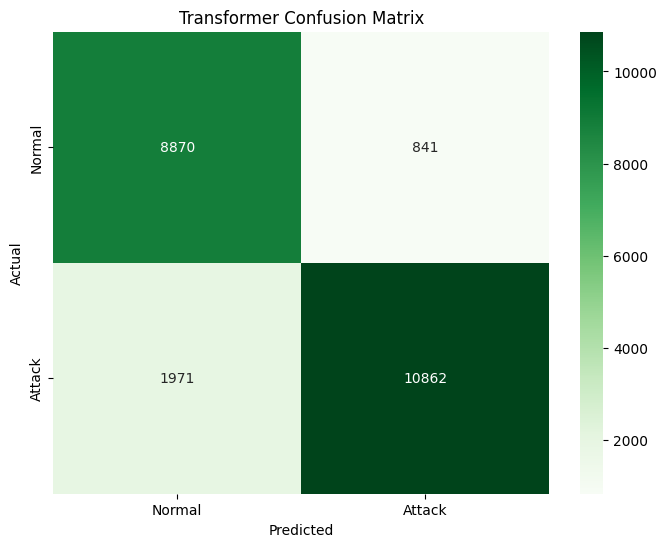

4256

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds, _ = predict(model, test_df, scaler, FEATURE_COLS, device)
y_true = test_df['binary_label'].values

print(f"Accuracy: {accuracy_score(y_true, all_preds):.4f}\n")
print(classification_report(y_true, all_preds, target_names=['Normal', 'Attack']))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, all_preds), annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Transformer Confusion Matrix')
plt.show()

# Cleanup
torch.cuda.empty_cache()
import gc
gc.collect()

## 7. Comparison with CNN

| Metric | CNN | Transformer |
|--------|-----|-------------|
| Accuracy | 79.96% | 87.53% |
| Attack Recall | 67% | 85% |
| Normal Recall | 97% | 91% |
| Attack Precision | 97% | 93% |
| Normal Precision | 69% | 82% |